(20640, 9)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154 

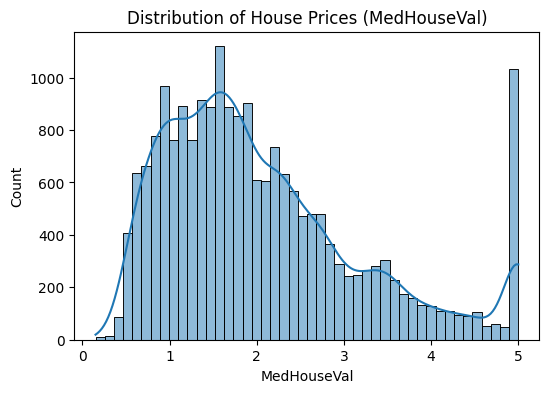

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = fetch_california_housing(as_frame=True)
df = data.frame  # dataframe có cả features + target

print(df.shape)
print(df.head())
print(df.describe())
print(df.isnull().sum())
print("Columns:", df.columns)

# Phân phối giá nhà (MedHouseVal)
plt.figure(figsize=(6,4))
sns.histplot(df['MedHouseVal'], kde=True)
plt.title('Distribution of House Prices (MedHouseVal)')
plt.show()


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# X: tất cả cột trừ target
X = df.drop(columns=['MedHouseVal']).values
y = df['MedHouseVal'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (16512, 8) Test: (4128, 8)


In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

pipe_rf = Pipeline([
    # RandomForest không cần scaler nhưng để thống nhất: có thể bỏ scaler
    ('model', RandomForestRegressor(random_state=42))
])


In [4]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

models = {
    'LinearRegression': pipe_lr,
    'Ridge': pipe_ridge,
    'RandomForest': pipe_rf
}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{name:15} | R²: {r2:.4f} | RMSE: {rmse:.4f}")


LinearRegression | R²: 0.5758 | RMSE: 0.7456
Ridge           | R²: 0.5758 | RMSE: 0.7456
RandomForest    | R²: 0.8051 | RMSE: 0.5053


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__n_estimators': 264}
Best CV R²: 0.8017899808562609


In [7]:
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("Best model on TEST:")
print(f"R²:   {r2_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")


Best model on TEST:
R²:   0.8062
RMSE: 0.5039


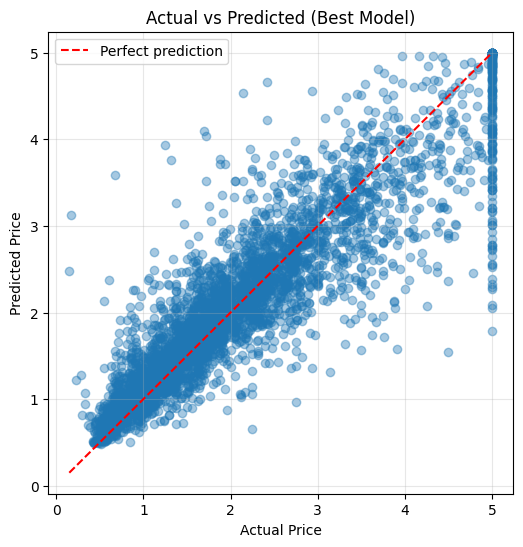

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Perfect prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted (Best Model)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


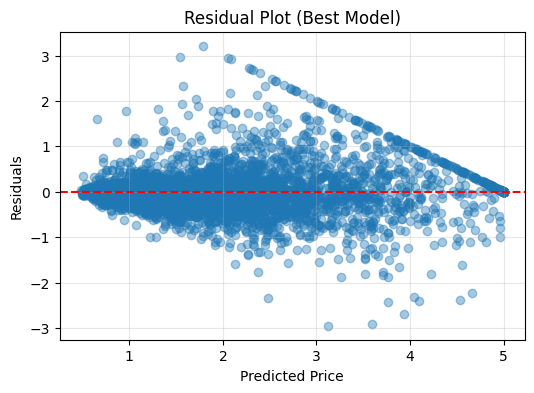

In [9]:
residuals = y_test - y_pred_best
plt.figure(figsize=(6,4))
plt.scatter(y_pred_best, residuals, alpha=0.4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot (Best Model)')
plt.grid(True, alpha=0.3)
plt.show()


In [10]:
import joblib

joblib.dump(best_model, 'models/house_price_model.pkl')
# sau này: loaded_model = joblib.load('models/house_price_model.pkl')


['models/house_price_model.pkl']